In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten
from google.colab import drive

In [3]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cwd = ("/content/gdrive/My Drive/")
main_path = os.path.join(cwd, "chest_xray")
train_path = os.path.join(main_path, "train")
val_path = os.path.join(main_path, "val")
test_path = os.path.join(main_path, "test")

In [5]:
#label 1
pne = "PNEUMONIA"
#label 0
nor = "NORMAL"

def get_paths_and_labels(directory, label):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg"):
            data.append([os.path.join(directory, filename), label])
    return data

#returns pandas dataframe of paths to images and their labels
def get_set(directory):
    pneumonia = os.path.join(directory, pne)
    normal = os.path.join(directory, nor)
    dataset = get_paths_and_labels(pneumonia, 1)
    dataset = pd.DataFrame(dataset, columns=list(["path", "label"]))
    dataset2 = get_paths_and_labels(normal, 0)
    dataset2 = pd.DataFrame(dataset2, columns=list(["path", "label"]))
    dataset = dataset.append(dataset2, ignore_index=True)
    return dataset

In [6]:
train = get_set(train_path)
val = get_set(val_path)
test = get_set(test_path)

In [8]:
train_data = np.asarray(train["label"])
(u_train, c_train) = np.unique(train_data, return_counts=True)
val_data = np.asarray(val["label"])
(u_val, c_val) = np.unique(val_data, return_counts=True)
test_data = np.asarray(test["label"])
(u_test, c_test) = np.unique(test_data, return_counts=True)

In [9]:
u_train

array([0, 1])

<BarContainer object of 2 artists>

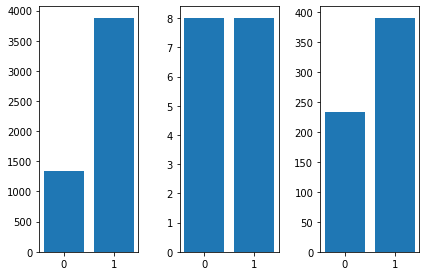

In [10]:
fig, axs = plt.subplots(1, 3)
fig.tight_layout() 
axs[0].bar(u_train, c_train)
axs[1].bar(u_val, c_val)
axs[2].bar(u_test, c_test)

###HERE: Show few examples from both classes

In [25]:
#Constants
SHAPE = (600, 400)
BATCH_SIZE = 32

In [26]:
train = train.append(val)
train_x, val_x, train_y, val_y = train_test_split(train["path"], train["label"], shuffle=True, test_size = 0.2, train_size = 0.8)

In [28]:
train = pd.concat([train_x, train_y.astype(str)], axis=1)
val = pd.concat([val_x, val_y.astype(str)], axis=1)

In [29]:
train_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=45,
    zoom_range=0.5,
    brightness_range=[0.75, 1.25],
)

val_gen = ImageDataGenerator(
    rescale=1/255.,
)

train_generator = train_gen.flow_from_dataframe(
        train,
        x_col="path",
        y_col="label",
        color_mode ="grayscale",
        target_size=SHAPE,
        batch_size=BATCH_SIZE)

val_generator = val_gen.flow_from_dataframe(
        val,
        x_col="path",
        y_col="label",
        color_mode ="grayscale",
        target_size=SHAPE,
        batch_size=BATCH_SIZE)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.


In [30]:
(unique, counts) = np.unique(train["label"], return_counts=True)
neg = counts[0]
pos = counts[1]
total = neg + pos

#taken from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


In [31]:
#adapted from https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
checkpoint_filepath = "/content/drive/My Drive/models"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [32]:
stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, baseline=0.9)

In [37]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(SHAPE[1], SHAPE[0], 1), padding="same"))
model.add(layers.MaxPooling2D((2, 2), padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2), padding="same"))
model.add(layers.Dropout(0.3))

for i in range(5):
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
  model.add(layers.MaxPooling2D((2, 2), padding="same"))
  model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2), padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(units = 256 , activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 128 , activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 2, activation="softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 400, 600, 32)      320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 200, 300, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 200, 300, 32)      9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 100, 150, 32)      0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 100, 150, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 100, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 50, 75, 64)       

In [38]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
#add callbacks e.g. saving early stopping etc.,  add plots of accuracy of the model

In [ ]:
SuperDuperModel = model.fit(train_generator, 
                            epochs = 10, 
                            verbose = 1, 
                            validation_data = val_generator,  
                            class_weight=class_weight, 
                            callbacks=[checkpoint],
                            stratify)

Epoch 1/10
131/131 [==============================] - 1290s 10s/step - loss: 0.3786 - accuracy: 0.8289 - val_loss: 0.3109 - val_accuracy: 0.8768
INFO:tensorflow:Assets written to: /content/drive/My Drive/models/assets
Epoch 2/10
131/131 [==============================] - 1290s 10s/step - loss: 0.3593 - accuracy: 0.8485 - val_loss: 0.4796 - val_accuracy: 0.7555
Epoch 3/10
131/131 [==============================] - 1290s 10s/step - loss: 0.3392 - accuracy: 0.8533 - val_loss: 0.3596 - val_accuracy: 0.7966
Epoch 4/10
131/131 [==============================] - 1291s 10s/step - loss: 0.3484 - accuracy: 0.8528 - val_loss: 0.2543 - val_accuracy: 0.9016
INFO:tensorflow:Assets written to: /content/drive/My Drive/models/assets
Epoch 5/10
131/131 [==============================] - 1288s 10s/step - loss: 0.3391 - accuracy: 0.8521 - val_loss: 0.4525 - val_accuracy: 0.8080
Epoch 6/10
 73/131 [===============>..............] - ETA: 8:57 - loss: 0.3075 - accuracy: 0.8656